In [49]:
import torch
import matplotlib.pyplot as plt

We have points distributed in a bordered world, in a square 1x1

tensor(2.2361)


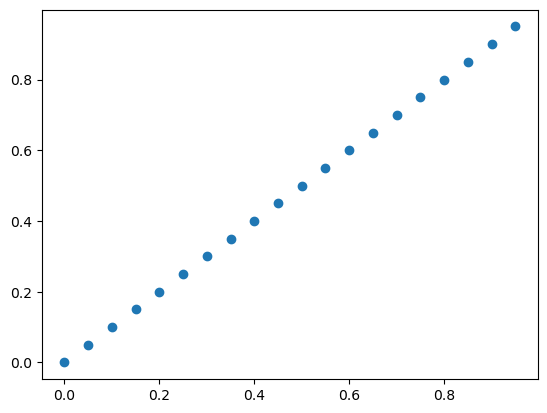

In [50]:
size = 20
T = 50
positions = (torch.stack([torch.arange(size), torch.arange(size)], dim=1).unsqueeze(0).float() / size).repeat(T, 1, 1)
#positions is of size T x N x 2, where T is the number of time steps, N is the number of objects, and 2 is the number of dimensions, here x and y
#show the positions
plt.scatter(positions[0,:,0], positions[0,:,1])

a = torch.tensor([1,2]).float()
print(torch.norm(a))
plt.show()

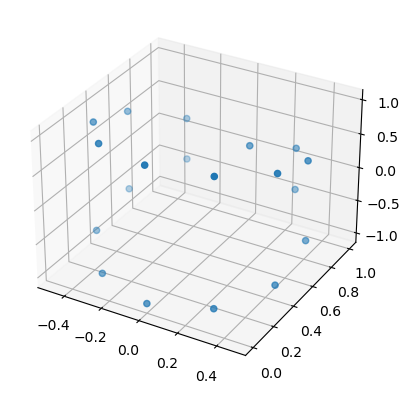

In [51]:
#first, we need to treat the coordinates just as latitudes and longitudes, so we need to convert them to radians
positions = positions * 2 * 3.14159265358979323846

#we want to project our (theta, phi) coordinates onto a sphere, so we need to convert them to (x, y, z) coordinates
#we can do this by using the following equations:
#x = r*sin(theta) * cos(phi)
#y = r*sin(theta) * sin(phi)
#z = r*cos(theta)
#we can do this in one line of code
positions = torch.stack((torch.sin(positions[:, :, 0]) * torch.cos(positions[:, :, 1]), torch.sin(positions[:, :, 0]) * torch.sin(positions[:, :, 1]), torch.cos(positions[:, :, 0])), dim=2)

#we can show them on a sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[0,:,0], positions[0,:,1], positions[0,:,2])

In [52]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph

#we can turn this into a knn graph
#first, we need to create a batch vector, which is just a vector of the same length as the number of nodes, where each element is the batch index
batch = torch.arange(T).repeat_interleave(size)
#we can then create a Data object
data = Data(x=positions, batch=batch)
#we can then create a knn graph

edge_index = knn_graph(data.x.reshape(-1,3), k=8, batch=data.batch)

In [53]:
print(edge_index)
print(edge_index.shape)

tensor([[ 19,   1,   2,  ..., 983, 996, 984],
        [  0,   0,   0,  ..., 999, 999, 999]])
torch.Size([2, 8000])


In [54]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx

#we can then convert this to a networkx graph
G = Data(pos=positions, edge_index=edge_index, batch=batch)
G_ =  to_networkx(G, to_undirected=True)

In [55]:
#show the graph
#nx.draw(G_, with_labels=True)

In [56]:
#we can compute the distances between each node along their edges for each time step
norm = lambda i,j : torch.norm(positions[edge_index[0,j], :] - positions[edge_index[1,j], :])

positions = positions.reshape(T*size, 3)

distances = torch.stack([norm(i,j) for i in range(edge_index.shape[0]) for j in range(edge_index.shape[1])], dim=0).reshape(edge_index.shape[0], edge_index.shape[1])

edge_attr = torch.norm(positions[edge_index[0, :], :3] - positions[edge_index[1, :], :3], dim=1).reshape(edge_index.shape[1], 1)
print(edge_attr)

tensor([[0.3129],
        [0.3129],
        [0.6180],
        ...,
        [1.0181],
        [1.0328],
        [1.1884]])


In [57]:
print(distances)
print(distances.shape)
print(edge_index.shape)
print(positions.shape)
print(edge_attr.shape)

tensor([[0.3129, 0.3129, 0.6180,  ..., 1.0181, 1.0328, 1.1884],
        [0.3129, 0.3129, 0.6180,  ..., 1.0181, 1.0328, 1.1884]])
torch.Size([2, 8000])
torch.Size([2, 8000])
torch.Size([1000, 3])
torch.Size([8000, 1])
